# ONNX graph, single or double floats

The notebook shows discrepencies obtained by using double floats instead of single float in two cases. The second one involves [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Simple case of a linear regression

A linear regression is simply a matrix multiplication followed by an addition: $Y=AX+B$. Let's train one with [scikit-learn](https://scikit-learn.org/stable/).

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [3]:
clr.score(X_test, y_test)

0.6819590064028198

In [4]:
clr.coef_

array([-9.07981994e-02,  4.44302900e-02, -8.85317288e-04,  3.20314197e+00,
       -1.66325521e+01,  4.36876222e+00, -5.84153853e-03, -1.43539722e+00,
        2.70681744e-01, -1.05730938e-02, -9.66491795e-01,  1.04555443e-02,
       -4.89380027e-01])

In [5]:
clr.intercept_

31.76589265802886

Let's predict with *scikit-learn* and *python*.

In [6]:
ypred = clr.predict(X_test)
ypred[:5]

array([11.39822099, 24.23808145,  5.76716757, 21.973409  , 20.70820046])

In [7]:
py_pred = X_test @ clr.coef_ + clr.intercept_
py_pred[:5]

array([11.39822099, 24.23808145,  5.76716757, 21.973409  , 20.70820046])

In [8]:
clr.coef_.dtype, clr.intercept_.dtype

(dtype('float64'), dtype('float64'))

## With ONNX

With *ONNX*, we would write this operation as follows... We still need to convert everything into single floats = float32.

In [9]:
%load_ext mlprodict

In [10]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxAdd
import numpy

onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float32), op_version=12),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'], op_version=12)
onnx_model32 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float32)},
                              dtype=numpy.float32)

# add -l 1 if nothing shows up
%onnxview onnx_model32

The next line uses a python runtime to compute the prediction.

In [11]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onnx_model32)
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([11.39822  , 24.23808  ,  5.7671623, 21.973406 , 20.708199 ],
      dtype=float32)

And here is the same with [onnxruntime](https://github.com/microsoft/onnxruntime)...

In [12]:
from mlprodict.tools.asv_options_helper import get_ir_version_from_onnx
# line needed when onnx is more recent than onnxruntime
onnx_model32.ir_version = get_ir_version_from_onnx()
oinf = OnnxInference(onnx_model32, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([11.39822  , 24.23808  ,  5.7671623, 21.973406 , 20.708199 ],
      dtype=float32)

## With double instead of single float

[ONNX](https://onnx.ai/) was originally designed for deep learning which usually uses floats but it does not mean cannot be used. Every number is converted into double floats.

In [13]:
onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float64), op_version=12),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'], op_version=12)
onnx_model64 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float64)},
                              dtype=numpy.float64)

And now the *python* runtime...

In [14]:
oinf = OnnxInference(onnx_model64)
ort_pred = oinf.run({'X': X_test})['Y']
ort_pred[:5]

array([11.39822099, 24.23808145,  5.76716757, 21.973409  , 20.70820046])

And the *onnxruntime* version of it.

In [15]:
oinf = OnnxInference(onnx_model64, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float64)})['Y']
ort_pred[:5]

array([11.39822099, 24.23808145,  5.76716757, 21.973409  , 20.70820046])

## And now the GaussianProcessRegressor

This shows a case

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
gau = GaussianProcessRegressor(alpha=10, kernel=DotProduct())
gau.fit(X_train, y_train)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [17]:
from mlprodict.onnx_conv import to_onnx
onnxgau32 = to_onnx(gau, X_train.astype(numpy.float32), dtype=numpy.float32)
oinf32 = OnnxInference(onnxgau32, runtime="python")
ort_pred32 = oinf32.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.squeeze(ort_pred32)[:25]

array([11.09375 , 24.8125  ,  6.75    , 22.46875 , 21.125   , 19.      ,
       35.1875  , 17.      , 21.125   , 32.359375, 20.65625 , 32.390625,
       23.953125, 32.375   , 21.3125  ,  3.34375 , 24.03125 , 14.375   ,
       21.390625, 21.921875, 21.34375 , 21.8125  , 31.375   , 26.140625,
       22.46875 ], dtype=float32)

In [18]:
onnxgau64 = to_onnx(gau, X_train.astype(numpy.float64), dtype=numpy.float64)
oinf64 = OnnxInference(onnxgau64, runtime="python")
ort_pred64 = oinf64.run({'X': X_test.astype(numpy.float64)})['GPmean']
numpy.squeeze(ort_pred64)[:25]

array([11.036315  , 24.53265956,  5.99817718, 22.05287978, 20.44294725,
       18.63491419, 34.95024805, 17.50070506, 20.73548306, 32.71043459,
       20.93037282, 32.29971413, 23.47245719, 32.23771885, 21.47279783,
        3.35833022, 23.44061984, 13.87669129, 21.83975365, 21.98003614,
       21.27806426, 21.80110641, 31.49139086, 26.30078255, 22.20209432])

The differences between the predictions for single floats and double floats...

In [19]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - ort_pred64)))[-5:]

array([0.68205275, 0.75182282, 0.78069378, 0.95523223, 0.97338865])

Who's right or wrong... The differences between the predictions with the original model...

In [20]:
pred = gau.predict(X_test.astype(numpy.float64))

In [21]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - pred)))[-5:]

array([0.68205275, 0.75182282, 0.78069378, 0.95523223, 0.97338865])

In [22]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred64 - pred)))[-5:]

array([0., 0., 0., 0., 0.])

Double predictions clearly wins.

In [23]:
# add -l 1 if nothing shows up
%onnxview onnxgau64

## Saves...

Let's keep track of it.

In [24]:
with open("gpr_dot_product_boston_32.onnx", "wb") as f:
    f.write(onnxgau32.SerializePartialToString())
from IPython.display import FileLink
FileLink('gpr_dot_product_boston_32.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_32.onnx

In [25]:
with open("gpr_dot_product_boston_64.onnx", "wb") as f:
    f.write(onnxgau64.SerializePartialToString())
FileLink('gpr_dot_product_boston_64.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_64.onnx

## Side by side

We may wonder where the discrepencies start. But for that, we need to do a side by side.

In [26]:
from mlprodict.onnxrt.validate.side_by_side import side_by_side_by_values
sbs = side_by_side_by_values([(oinf32, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])

from pandas import DataFrame
df = DataFrame(sbs)
# dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
df

,metric,step,v[0],v[1],cmp,name,value[0],shape[0],value[1],shape[1]
0,nb_results,-1,10,1.000000e+01,OK,NaN,NaN,NaN,NaN,NaN
1,abs-diff,0,0,4.959520e-08,OK,X,"[[0.28955, 0.0, 10.59, 0.0, 0.489, 5.412, 9.8,...","(127, 13)","[[0.28955, 0.0, 10.59, 0.0, 0.489, 5.412, 9.8,...","(127, 13)"
2,abs-diff,1,0,3.461630e-02,e<0.1,GPmean,"[[11.09375, 24.8125, 6.75, 22.46875, 21.125, 1...","(1, 127)","[[11.036314999510068, 24.532659563585185, 5.99...","(1, 127)"
3,abs-diff,2,0,5.319741e-08,OK,kgpd_MatMulcst,"[[0.04294, 0.05515, 0.03427, 7.99248, 0.03445,...","(13, 379)","[[0.04294, 0.05515, 0.03427, 7.99248, 0.03445,...","(13, 379)"
4,abs-diff,3,0,3.408731e-08,OK,kgpd_Addcst,[542.717],"(1,)",[542.7169984802321],"(1,)"
5,abs-diff,4,0,5.103052e-08,OK,gpr_MatMulcst,"[-0.4783848, 0.24004003, -0.16596864, -0.05629...","(379,)","[-0.47838478503874776, 0.2400400335277627, -0....","(379,)"
6,abs-diff,5,0,0.000000e+00,OK,gpr_Addcst,[[0.0]],"(1, 1)",[[0.0]],"(1, 1)"
7,abs-diff,6,0,1.856238e-07,OK,kgpd_Y0,"[[215454.33, 200458.2, 202325.83, 325922.2, 23...","(127, 379)","[[215454.32982825724, 200458.20403216276, 2023...","(127, 379)"
8,abs-diff,7,0,1.856238e-07,OK,kgpd_C0,"[[215454.33, 200458.2, 202325.83, 325922.2, 23...","(127, 379)","[[215454.32982825724, 200458.20403216276, 2023...","(127, 379)"
9,abs-diff,8,0,1.856238e-07,OK,kgpd_output0,"[[215454.33, 200458.2, 202325.83, 325922.2, 23...","(127, 379)","[[215454.32982825724, 200458.20403216276, 2023...","(127, 379)"


The differences really starts for output ``'O0'`` after the matrix multiplication. This matrix melts different number with very different order of magnitudes and that alone explains the discrepencies with doubles and floats on that particular model.

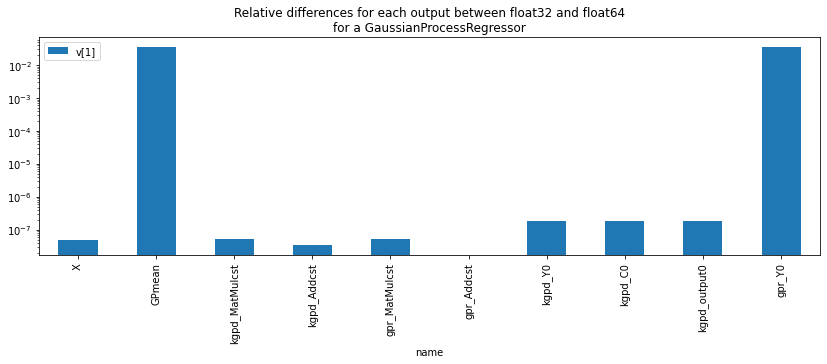

In [27]:
%matplotlib inline
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float32 and float64\nfor a GaussianProcessRegressor");

Before going further, let's check how sensitive the trained model is about converting double into floats.

In [28]:
pg1 = gau.predict(X_test)
pg2 = gau.predict(X_test.astype(numpy.float32).astype(numpy.float64))
numpy.sort(numpy.sort(numpy.squeeze(pg1 - pg2)))[-5:]

array([1.54436566e-06, 1.57894101e-06, 1.70845306e-06, 1.75694004e-06,
       2.00257637e-06])

Having float or double inputs should not matter. We confirm that with the model converted into ONNX.

In [29]:
p1 = oinf64.run({'X': X_test})['GPmean']
p2 = oinf64.run({'X': X_test.astype(numpy.float32).astype(numpy.float64)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(p1 - p2)))[-5:]

array([1.54436566e-06, 1.57894101e-06, 1.70845306e-06, 1.75694004e-06,
       2.00257637e-06])

Last verification.

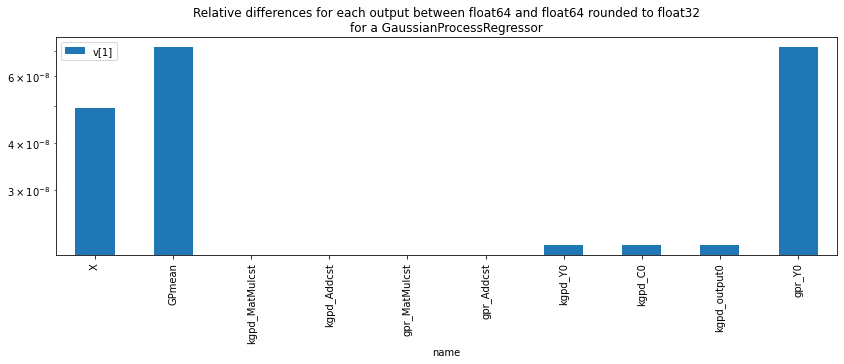

In [30]:
sbs = side_by_side_by_values([(oinf64, {'X': X_test.astype(numpy.float32).astype(numpy.float64)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");